In [1]:
from dataclasses import dataclass, field
from typing import Annotated, List, TypedDict

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_community.embeddings import FastEmbedEmbeddings
from langchain_core.documents import Document
from langchain_core.messages import AnyMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

In [2]:
llm = init_chat_model("qwen3:8b", model_provider="ollama")

## Workflow


In [3]:
@dataclass
class TicketTriageState:
    ticket_text: str
    classification: str = ""
    retrieved_docs: List[Document] = field(default_factory=lambda: [])
    draft_response: str = ""
    evaluation_feedback: str = ""
    revision_count: int = 0

### Nodes


In [4]:
CLASSIFY_PROMPT = """
Classify this support ticket into one of the following categories: 
'Technical Issue', 'Billing Inquiry', 'General Question'. 

<ticket>
{ticket_text}
</ticket>
""".strip()


def classify_ticket(state: TicketTriageState) -> dict:
    classification = llm.invoke(CLASSIFY_PROMPT.format(ticket_text=state.ticket_text))
    return {"classification": classification}

In [5]:
knowledge_base = [
    "For login issues, tell the user to try resetting their password via the 'Forgot Password' link.",
    "Billing inquiries should be escalated to the billing department by creating a ticket in Salesforce.",
    "The app is known to crash on startup if the user's cache is corrupted. The standard fix is to clear the application cache.",
]

embeddings = FastEmbedEmbeddings()
vector_store = InMemoryVectorStore.from_texts(knowledge_base, embeddings)
retriever = vector_store.as_retriever()


def retrieve_knowledge(state: TicketTriageState) -> dict:
    retrieved_docs = retriever.invoke(state.ticket_text)
    return {"retrieved_docs": retrieved_docs}

In [6]:
DRAFT_PROMPT = """
Based on this context:
<context>
{context}
</context>

Draft a response for this ticket:
<ticket>
{ticket_text}
</ticket>
""".strip()


def draft_response(state: TicketTriageState) -> dict:
    context = "\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = DRAFT_PROMPT.format(context=context, ticket_text=state.ticket_text)
    draft = llm.invoke(prompt)
    return {"draft_response": draft}

In [7]:
EVALUATE_PROMPT = """
Does this draft 
<draft>
{draft_response}
</draft>

fully address the ticket 

<ticket>
{ticket_text}
</ticket>
 
If not, provide feedback. 
Respond with 'PASS' or 'FAIL: [feedback]'."
""".strip()


def evaluate_draft(state: TicketTriageState) -> dict:
    evaluation_prompt = EVALUATE_PROMPT.format(
        draft_response=state.draft_response, ticket_text=state.ticket_text
    )
    evaluation_result = llm.invoke(evaluation_prompt)
    revision_count = state.revision_count + 1
    return {"evaluation_feedback": evaluation_result, "revision_count": revision_count}

In [8]:
REVISE_PROMPT = """
Revise this draft:
<draft>
{draft_response}
</draft>

based on the following feedback:

<feedback>
{evaluation_feedback}
</feedback>
""".strip()


def revise_response(state: TicketTriageState) -> dict:
    revised_draft = llm.invoke(
        REVISE_PROMPT.format(
            draft_response=state.draft_response,
            evaluation_feedback=state.evaluation_feedback,
        )
    )
    return {"draft_response": revised_draft}

In [9]:
def should_revise(state: TicketTriageState) -> str:
    feedback = state.evaluation_feedback
    revision_count = state.revision_count

    if "FAIL" in feedback and revision_count < 3:
        return "revise"
    else:
        return "end"

### Graph


In [10]:
graph = StateGraph(TicketTriageState)

# Nodes
graph.add_node("classify", classify_ticket)
graph.add_node("retrieve", retrieve_knowledge)
graph.add_node("draft", draft_response)
graph.add_node("evaluate", evaluate_draft)
graph.add_node("revise", revise_response)


# Edges
graph.add_edge("classify", "retrieve")
graph.add_edge("retrieve", "draft")
graph.add_edge("draft", "evaluate")

graph.add_edge("revise", "evaluate")

graph.add_conditional_edges(
    "evaluate",
    should_revise,
    {
        "revise": "revise",
        "end": END,
    },
)

graph.set_entry_point("classify")
app = graph.compile()

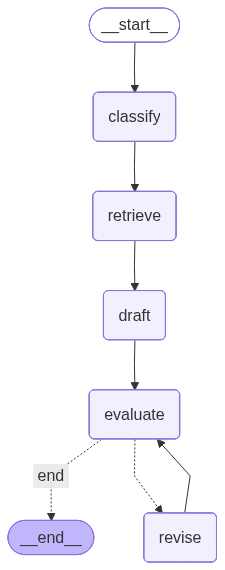

In [11]:
display(Image(app.get_graph().draw_mermaid_png()))

## Run the Workflow


In [12]:
initial_state = TicketTriageState(ticket_text="My login is broken, please help!")
final_state = app.invoke(initial_state)

In [13]:
print(final_state["classification"].content)

<think>
Okay, let me figure out how to classify this support ticket. The user says, "My login is broken, please help!" So first, I need to determine which category this falls into: Technical Issue, Billing Inquiry, or General Question.

Looking at the message, the user is having trouble with their login. That sounds like a problem with the website or application they're using. Login issues typically relate to technical problems, like authentication errors, server issues, or account lockouts. Since the user is asking for help with a broken login, it's probably a technical issue. 

Billing inquiries usually involve questions about payments, invoices, subscriptions, etc. The user didn't mention anything related to billing, so that's probably not it. A general question might be something like needing help finding a feature or understanding a policy, but the user is specifically talking about their login not working. 

So, based on the description, the most appropriate category is 'Technica

In [14]:
print(final_state["revision_count"])

1


In [15]:
print(final_state["draft_response"].content)

<think>
Okay, the user is having a login issue. Let me check the context provided. The first point says to tell them to try resetting their password via the 'Forgot Password' link. So that's the first step I should mention. 

Wait, but maybe their cache is corrupted too? The context mentions that the app crashes on startup if the cache is corrupted, and the fix is to clear the cache. But the user's issue is login, not a crash on startup. Hmm, but maybe the cache issue could be related. Should I mention clearing the cache as an additional step?

The context also says billing inquiries go to Salesforce, but this is a login issue, so that's probably not relevant here. 

So the main steps are: reset password via the Forgot Password link. Then, if that doesn't work, maybe check the cache. But the user's ticket is just "My login is broken, please help!" So I should prioritize the password reset first. Maybe mention that if they can't reset the password, they can try clearing the cache. But I

## Agent


### Tools


In [16]:
@tool
def classify_ticket(ticket_text: str) -> str:
    """
    Classifies a support ticket into 'Technical Issue', 'Billing Inquiry', or 'General Question'.
    Use this tool first to understand the nature of the ticket.
    """
    return llm.invoke(CLASSIFY_PROMPT.format(ticket_text=ticket_text)).content.strip()


@tool
def retrieve_knowledge(ticket_text: str) -> list[str]:
    """
    Retrieves relevant knowledge base articles for a given ticket.
    Use this for 'Technical Issue' tickets to find potential solutions.
    """
    return [doc.page_content for doc in retriever.invoke(ticket_text)]


@tool
def draft_response(ticket_text: str, context: list[str]) -> str:
    """
    Drafts a helpful response to a support ticket, using provided context.
    """
    context_str = "\n".join([doc for doc in context])
    return llm.invoke(
        DRAFT_PROMPT.format(context=context_str, ticket_text=ticket_text)
    ).content.strip()


tools = [classify_ticket, retrieve_knowledge, draft_response]

### Nodes


In [17]:
AGENT_SYSTEM_PROMPT = """
You are an expert support ticket triager. Your goal is to process a user's ticket by taking the following steps:
1. First, classify the ticket to understand its category.
2. If the ticket is a 'Technical Issue', retrieve relevant knowledge.
3. Finally, draft a response to the user.
You must use the provided tools to perform these actions in sequence. Respond ONLY with the final drafted response once all steps are complete.
"""

agent_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", AGENT_SYSTEM_PROMPT),
        ("placeholder", "{messages}"),
    ]
)

llm_with_tools = llm.bind_tools(tools)
agent = agent_prompt | llm_with_tools

In [18]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


def agent_node(state: AgentState):
    response = agent.invoke(state)
    return {"messages": [response]}

In [19]:
tool_node = ToolNode(tools)


def should_continue(state: AgentState) -> str:
    """
    Determines whether to continue the loop by calling tools or end the process.
    """
    last_message = state["messages"][-1]
    if not last_message.tool_calls:
        return "end"
    return "continue"

### Graph


In [20]:
agent_graph = StateGraph(AgentState)

agent_graph.add_node("agent", agent_node)
agent_graph.add_node("tools", tool_node)

agent_graph.set_entry_point("agent")

agent_graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

agent_graph.add_edge("tools", "agent")

agent_app = agent_graph.compile()

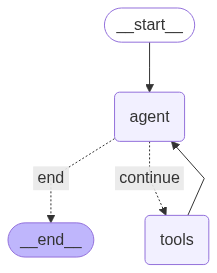

In [21]:
display(Image(agent_app.get_graph().draw_mermaid_png()))

### Run the Agent


In [22]:
initial_state = AgentState(
    messages=[HumanMessage(content="My login is broken, please help!")]
)
for entry in agent_app.stream(initial_state, stream_mode="updates"):
    messages_dict = next(iter(entry.values()))
    message = messages_dict["messages"][0]
    if "agent" in entry:
        print("Agent")
        print(message.content)
        if message.tool_calls:
            print("Tool calls:")
            print(message.tool_calls)
    elif "tools" in entry:
        print("Tool response:")
        print(message.content)
    print()
    print("---")
    print()

Agent
<think>
Okay, the user says, "My login is broken, please help!" Let me break this down.

First, I need to classify the ticket. The user is having trouble logging in, which sounds like a technical issue. The classify_ticket function should handle this. The parameters require the ticket_text, which is the user's message. So I'll call classify_ticket with that text.

Once classified as a Technical Issue, the next step is to retrieve relevant knowledge. Using retrieve_knowledge with the same ticket_text to find articles related to login problems. This will help identify possible solutions.

After getting the knowledge articles, I'll use draft_response. The context from retrieve_knowledge will be used here along with the ticket_text to create a helpful reply. The response should address the login issue based on the retrieved info.

I need to make sure each step is followed in order: classify, retrieve, then draft. Each function call is necessary to build the response properly. Let me 